### 一、主题

   Analyze the stock return data, test the result of different variable selection methods for index tracking.

### 二、解答

In [1]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
import os

### （一）子集筛选的方法

#### 1.forward

In [2]:
def forward0(X,y):
    n,p = X.shape
    seq = []
    inv_seq = list(range(p))
    for j in range(p):
        beta = la.pinv(X[:,seq].T.dot(X[:,seq])).dot(X[:,seq].T).dot(y)
        Z = y - X[:,seq].dot(beta)
        tmp = np.hstack((Z,X[:,inv_seq]))
        corr0 = np.corrcoef(tmp.T)
        id = np.abs(corr0[0,1:]).argmax()
        seq.append(inv_seq[id])
        del inv_seq[id]
    return seq

#### 2.forward stepwise

In [3]:
def forward_sw(X,y,eps):
    n,p = X.shape
    beta = np.zeros((p,1))
    iter = 0
    beta_seq = []
    max_cor = 1
    while max_cor > 0.01 and iter <100:
        for j in range(p):
            Z = y - X.dot(beta)
            tmp = np.hstack((Z,X))
            corr0 = np.corrcoef(tmp.T)
            max_cor = np.abs(corr0[0,1:]).max()
            id = np.abs(corr0[0,1:]).argmax()
            sgn = np.sign(corr0[0,1:][id])
            beta[id] = beta[id] + eps*sgn
        beta_seq.append(beta.copy())
        iter = iter +1
    return beta,beta_seq,iter


#### 3.coordinate decent algorithm

In [4]:
def sfun(t,ld):
    tmp = (np.abs(t)-ld)
    if tmp < 0:
        tmp = 0
    return np.sign(t)*tmp


In [5]:
def coordinate(X,y,beta0,ld):
    beta = beta0.copy()
    n,p = X.shape
    iter = 0
    diff = 1
    VAL = 10000
    while iter<1000 and diff>0.0001:
        for j in range(p):
            beta[j] = 0
            y2 = y - X.dot(beta)
            t = X[:,j].dot(y2)
            beta[j] = sfun(t,n*ld)/(X[:,j]**2).sum()
        VAL2 = np.sum((y-X.dot(beta))**2) + \
        n*ld*np.sum(np.abs(beta))
        diff = np.abs(VAL2 - VAL)
        VAL = VAL2
        iter = iter + 1
    return beta,iter

### （二）回归

#### 1.读入数据

In [6]:
os.chdir(r'D:\研一下\data mining\data')

In [7]:
index_path = 'SZ399300.TXT'
index300 = pd.read_table(index_path,\
    encoding = 'cp936',header = None)
index2 = index300[:-1] #去除'1340  数据来源:通达信'行
index2.columns = ['date','o','h','l','c','v','to']
index2.index = index2['date'] #日

In [8]:
index2.head(10)

,date,o,h,l,c,v,to
date,,,,,,,
20100602,20100602,2729.33,2757.91,2700.07,2757.53,39587020.0,4.636423e+10
20100603,20100603,2769.10,2787.51,2735.70,2736.08,39587258.0,4.714326e+10
20100604,20100604,2721.36,2748.48,2713.09,2744.39,32746291.0,3.985836e+10
20100607,20100607,2692.83,2716.40,2673.34,2695.72,39541993.0,4.706270e+10
20100608,20100608,2694.11,2720.59,2672.06,2699.34,35140182.0,4.267710e+10
20100609,20100609,2711.64,2787.82,2687.33,2782.13,60209533.0,7.071008e+10
20100610,20100610,2755.94,2776.26,2746.11,2750.02,42906334.0,5.031225e+10
20100611,20100611,2766.20,2782.09,2755.95,2758.87,40558585.0,4.887148e+10
20100617,20100617,2778.53,2784.92,2742.64,2742.73,32612356.0,4.029323e+10


In [9]:
index2.shape#上证指数收盘价

(1340, 7)

In [10]:
stock_path = r'D:\研一下\data mining\data\hs300-2\hs300'
os.chdir(stock_path)

names = os.listdir(stock_path)
close = []

for spath in names:
    tmp = pd.read_table(spath,encoding = 'cp936',header = None)
    df = tmp[:-1]
    df.columns = ['date','o','h','l','c','v','to']
    df.index = df['date']
    df1 = df.reindex(index2.index, method = 'ffill')
    df2 = df1.fillna(method = 'bfill')
    close.append(df2['c'].values) #提出收盘价


In [11]:
close = np.asarray(close).T 

In [12]:
np.shape(close)

(1340, 300)

In [13]:
retx = (close[1:,:] - close[0:-1,:])/close[0:-1,:]

In [14]:
#计算收益率
np.shape(retx)

(1339, 300)

In [15]:
#计算指数收益率
idc = index2['c'].values
y = ((idc[1:] - idc[0:-1])/idc[:-1]).reshape(1339,1)

In [16]:
np.shape(y)

(1339, 1)

In [17]:
#计算股票平均收益率
y2 = retx.mean(axis = 1).reshape(1339,1)

In [18]:
np.shape(y2)

(1339, 1)

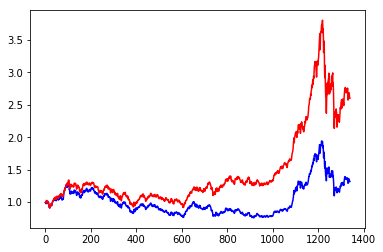

In [19]:
plt.plot(np.cumprod(1+y),'b') #连乘
plt.plot(np.cumprod(1+y2),'r')

             图1 均值指数追踪

#### 2.forward regression

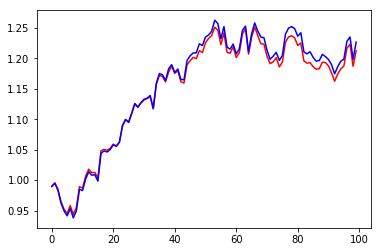

In [21]:
X = retx
seq0 = forward0(X[:600,:],y2[:600,:])
id = seq0[:150]
beta0 = la.pinv(X[:600,id].T.dot(X[:600,id])).dot(X[:600,id].T).dot(y2[:600,:])
yest = X[600:700,id].dot(beta0)
plt.plot(np.cumprod(1+yest),'r')
plt.plot(np.cumprod(1+y2[600:700]),'b')

             图2 forward regression指数追踪

#### 2.forward stepwise regression

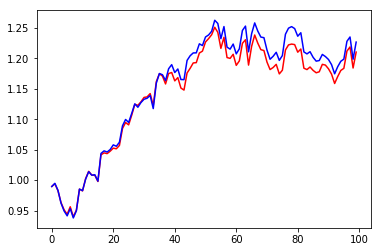

In [22]:
X = retx
y2 = retx.mean(axis = 1).reshape(1339,1)
X = retx[:600,:]+1e-10
y= y2[:600,:]
beta0, beta_seq,iter = forward_sw(X,y,0.005)
yest = retx[600:700,:].dot(beta0)
plt.plot(np.cumprod(1+yest),'r')
plt.plot(np.cumprod(1+y2[600:700,:]),'b')
plt.show()

         图3 forward stepwise regression指数追踪

#### 3.coordinate decent algorithm regression

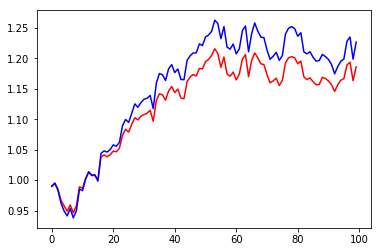

In [23]:
X = retx
y2 = retx.mean(axis = 1).reshape(1339,1)
X = retx[:600,:]+1e-10
y= y2[:600,:]
beta_ols = la.pinv(X.T.dot(X)).dot(X.T).dot(y)
beta0,iter = coordinate(X,y,beta_ols,0.00001) #选择不同的惩罚项，拟合的效果不一样，惩罚项越大，β的压缩力度越大
yest = retx[600:700,:].dot(beta0)
plt.plot(np.cumprod(1+yest),'r')
plt.plot(np.cumprod(1+y2[600:700,:]),'b')
plt.show()

图4 coordinate decent algorithm regression 指数追踪

## （三）结果解析

本次作业利用沪深300的成分股，来追踪沪深300指数，即通过子集筛选的方式选取成分股，将其收益率作为自变量去拟合预测hs300的收益率。子集的选取方式包括forward方法，其基本思想是不断选取与回归残差相关系数最大的自变量进入回归子集中。首先，我们把前600个交易日当做训练数据集，后100个交易日收益率当做测试集。根据forward方法选出的自变量序列已经根据相关系数排好序。然后我们选取了子集中的前150支股票收益率作为自变量去预测测试集。得到图一，可以看到，在前40天模型的效果都是比较好的，较远的天数出现了偏差。

forward stepwise方法则是不断计算全部的自变量与残差的相关系数，将初始的贝塔估计定位OLS估计的贝塔值，通过加上（相关系数大于0）或减去（相关系数小于0）一个很小的整数去更新相关系数大的自变量的贝塔值，再重新计算残差，重复以上步骤。使用该方法进行估计得到图二，其效果不如forward方法。

coordinate decent algorithm通过固定坐标来更新贝塔的值，因为在其他参数固定的情况下，要求损失函数的是有显示解的。这个使得损失函数最小的解可以当做新的未固定坐标的贝塔值，然后继续选取未固定参数。此处定义的梯度下降算法是lasso回归。lasso回归本身就具有选择子集的功能。lambda值越大，则β被压缩的越厉害。本次作业选择的lambda值较小，但是预测的效果仍然比较差。

综上所述，forward回归较好。